In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
%matplotlib inline

def load_data(file_name, direction=0):
    """load data and make feature data X and label data Y.
    
    Parameters:
        file_name: the path of file to be loaded.
        direction: 0 for northbound，180 for southbound.
        
    Returns:
        pd.DataFrame(feature_data): the dataframe of feature data. 
        pd.DataFrame(label_data): the dataframe of label data.
    """
    speed_file = pd.read_csv(file_name)
    speed_data = {}
    for index, row in speed_file.iterrows():
        if len(row['datetime'].split(' ')) == 1:
            day, time_point = 0, row['datetime']
        else:
            day, time_point = row['datetime'].split(' ')
        cur = int((int(time_point.split(':')[0]) * 60 + int(time_point.split(':')[1])) / 5)
        if not day in speed_data:
            speed_data[day] = {}
        speed_data[day][cur] = row['speed']

    feature_data = []
    label_data = []
    
    # the time index for prediction
    label_index_range = list(range(72, 132)) + list(range(192, 252))
    # the time index for features
    feature_index_range = list(range(0, 72)) + list(range(132, 192)) + list(range(252, 288))
    
    # construct data
    for day_time, day_data in speed_data.items():
        for label_index in label_index_range:
            if not label_index in day_data:
                continue

            feature = {}
            flag = 0
            for feature_index in feature_index_range:
                if not feature_index in day_data:
                    day_data[feature_index] = 0
                # handling outliers
                if feature_index > 0 and (feature_index + 1) in day_data:
                    mid_data = (day_data[feature_index-1] + day_data[feature_index+1]) / 2.0
                    if day_data[feature_index] < mid_data / 3 or \
                        day_data[feature_index] > mid_data * 3:
                            feature['time'+str(feature_index)] = day_data[feature_index]
                            continue
                            pass
                feature['time'+str(feature_index)] = day_data[feature_index]
            
            # use time index as model features.
            feature['cur_time'] = label_index
            # use direction as model features.
            feature['direction'] = direction
            feature_data.append(feature)
            label_data.append(day_data[label_index])

    return pd.DataFrame(feature_data), pd.DataFrame(label_data)

(6960, 170)
(6960, 1)
[[25.61813834]
 [32.25715114]
 [38.89616394]
 [36.93937595]
 [21.33523515]
 [12.16071074]
 [24.9584859 ]
 [31.38789483]
 [42.48969732]
 [27.56161208]
 [38.88378029]
 [26.01727807]
 [31.97009934]
 [29.53519025]
 [28.07856869]
 [29.2235029 ]
 [28.54541817]
 [17.62981843]
 [14.08093909]
 [20.34814634]
 [13.73648491]
 [13.95765929]
 [11.04988607]
 [ 7.52720544]
 [12.97526992]
 [10.45764232]
 [11.65139345]
 [11.67085424]
 [14.24025135]
 [14.39258064]
 [15.40405971]
 [13.1608671 ]
 [20.86613522]
 [19.04895533]
 [16.68524931]
 [19.04311535]
 [21.85706469]
 [25.64204879]
 [22.78686056]
 [25.84764393]
 [21.28585516]
 [27.39099781]
 [20.26327027]
 [24.30604858]
 [21.00433156]
 [19.29980468]
 [17.62371125]
 [18.90824564]
 [20.76614838]
 [21.71918563]
 [22.54699498]
 [20.79748468]
 [21.40132592]
 [20.89128173]
 [19.90441792]
 [19.13195106]
 [21.32142243]
 [18.9445297 ]
 [18.81344437]
 [20.38275201]
 [21.38582744]
 [18.56528083]
 [22.57424589]
 [23.94593052]
 [21.51352945]
 [1

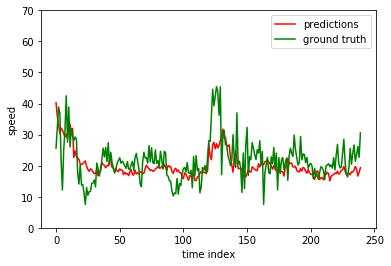

In [27]:
#validation on seven different folds.
mse_all = []
direction = 0
for cur_file in range(1,2):

    file1 = 'validation/north/training_data_fold{}.csv'.format(str(cur_file))
    test1 = 'validation/north/ground_truth_for_test/test_data_fold{}_answer.csv'.format(str(cur_file))
    file2 = 'validation/south/training_data_fold{}.csv'.format(str(cur_file))
    test2 = 'validation/south/ground_truth_for_test/test_data_fold{}_answer.csv'.format(str(cur_file))
    x_north_train, y_north_train = load_data(file1)
    x_north_test, y_north_test = load_data(test1)
    x_south_train, y_south_train = load_data(file2, direction)
    x_south_test, y_south_test = load_data(test2, direction)
    x_train = x_north_train.append(x_south_train)
    y_train = y_north_train.append(y_south_train)
    x_test = x_north_test
    y_test = y_north_test
    x_test = x_north_test.append(x_south_test)
    y_test = y_north_test.append(y_south_test)


    print(x_train.shape)
    print(y_train.shape)


    ss_X = StandardScaler()
    ss_y = StandardScaler()

    x_train = ss_X.fit_transform(x_train)
    x_test = ss_X.fit_transform(x_test)
    y_train = ss_y.fit_transform(y_train)
    y_test = ss_y.fit_transform(y_test)



    #random forest
    model = RandomForestRegressor()
    model.fit(x_train, y_train.ravel())
    y_predict = model.predict(x_test)



    mse = mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict))
    mse_all.append(mse)
    print(ss_y.inverse_transform(y_test))
    print(ss_y.inverse_transform(y_predict))
    print(mse)

    plt.plot(ss_y.inverse_transform(y_predict),'r',label='predictions')
    plt.plot(ss_y.inverse_transform(y_test),'g',label='ground truth')
    plt.legend()
    plt.xlabel('time index')
    plt.ylabel('speed')
    plt.ylim((0,70))
    plt.show()



In [17]:
np.mean(mse_all)

35.230317346536175

In [18]:
mse_all

[36.13332664821855,
 32.94335410554813,
 62.61812322994695,
 28.316021999572307,
 29.210714331071756,
 33.330080317718725,
 24.060600793676766]

25.674343417444934


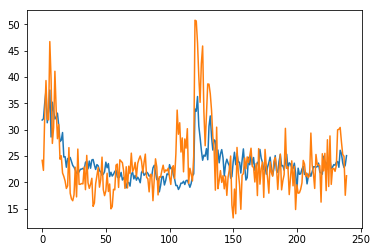

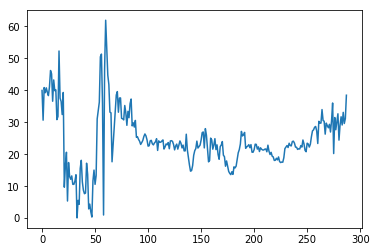

In [10]:
prediction_file = 'cleaned_Predictions_north.csv'

test_data_ori, _ = load_data(prediction_file, 0)
test_data = ss_X.fit_transform(test_data_ori)
result = ss_y.inverse_transform(model.predict(test_data))

index = 0
result = result.tolist()

res_file = pd.read_csv(prediction_file)
for index, row in test_data_ori.iterrows():
    row_num = int(row['cur_time'])
    res_file.loc[row_num, 'speed'] = result[index]
    

res_file.to_csv(prediction_file.split('.')[0]+'_res.csv',index=False,sep=',')

#预测天级图
plt.plot(res_file.speed)
plt.show()




In [250]:
from sklearn.externals import joblib

joblib.dump(model, 'rf.model')

['rf1.model']